### Importing dataset from kaggle

In [1]:
! pip install kaggle

In [2]:
! mkdir /root/.kaggle

In [3]:
! cp kaggle.json /root/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:10<00:00, 130MB/s]
100% 1.33G/1.33G [00:10<00:00, 131MB/s]


In [6]:
!unzip celeba-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Deep convolutional GANs (DCGAN) Implementation Using celeba dataset & pytorch
For training data I used a famous dataset of Celebrate people from kaggle : https://www.kaggle.com/jessicali9530/celeba-dataset
Or you can use the image that ypu find it in this github repo : 
(it contains part of the celeba dataset & you can use it to test your dcgan model)

1. Installation:
For the implementation if you want to do it in your own computer you will need first to install :
    - Python 3.8 : https://www.python.org/downloads/
    - Anaconda : https://docs.anaconda.com/anaconda/install/index.html
    - Install pyrotch labrary in anaconda : 
       - Go to  anaconda Powershell Prompt, then tape the following cmd :    
                    conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
    - And to check that your installation is right use that cmd :
                    conda list torch
    - Or you can skip all this installation and use colab : https://colab.research.google.com/
2.   Import the following libraries 




In [7]:
# Here we do the importation of necessairy libraries
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from torchvision.models import inception_v3
manualSeed = 999
#Seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Create DCGAN model :

3.  Define inputs for our model or what we call it hyperparameters :
    *   **dataroot** : it’s for the path to the root directory where we put our dataset.

    *   **workers** : number of threads used to download the dataset.

    *   **batch_size** : it’s the batch size for the training & in the DCGAN paper they use 128.

    *   **image_size** : it define the size of the images used in the trainning,we will use 64*64.

    *   **nc** :it's the number of color channels used in input image,its value is 3 (RGB mode).

    *   **nz** : length of latent vector (Noise vector).

    *   **ngf** : it define the depth of feature maps carried through the generator.

    *   **ndf** : it define the depth of feature maps propagated through the discriminator.

    *   **num_epochs** : it define the number of training epochs to run

    *   **lr** : learning rate ,as it mentioned in the DCGAN paper , lr should be 0.0002

    *   **beta1** : it’s hyperparameter for Adam optimizers,as it mentioned also in the DCGAN paper,it should have 0.5 value.

    *   **ngpu** : number of the gpu available in your computer (0 : code will be executed in cpu , >0  :  it will be executed on the number of GPU).






In [21]:
#Here we do the declaration of the parameters that we will need it
#dataroot = "celeba_100"
dataroot = "img_align_celeba"
#dataroot = "drive/MyDrive/Celeba_100/"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 20
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [ ]:
ls drive/MyDrive/Celeba_100/

img_align_celeba/


4.   Load the dataset by creating a dataset variable & dataLoader and finally we can choose the device in which we run the code.
5. Visualize some training images from the celeba dataset.


In [9]:
# Here We can use an image folder dataset the way we have it setup.
# We Create the dataset
def load_data(dataroot,image_size,batch_size,workers,ngpu):
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)
    return dataloader
 


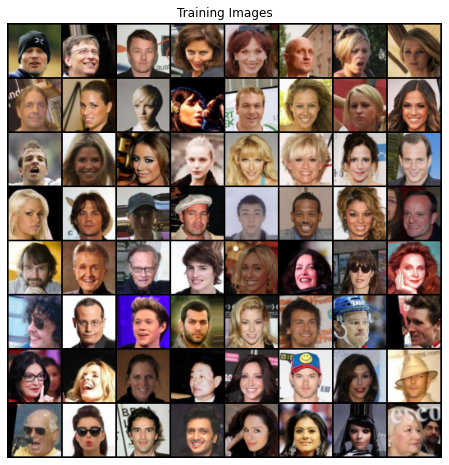

In [10]:
dataloader=load_data(dataroot,image_size,batch_size,workers,ngpu)
 # Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

  
#visualise training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

6. Create Weights initialisation :   
From the DCGAN paper, all model weights are initialized randomly from a  Normal distribution with mean=0, standard_deviation=0.02. 

In [11]:
# weights initialization called on generator network  and descriminator network
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

7. Create the generator network :     
first we need to convert the random vector (z) from vector to image data and then reshape our data as following : 
  *   **100x1 → 1024x4x4 → 512x8x8 → 256x16x16 → 128x32x32 → 64x64x3**

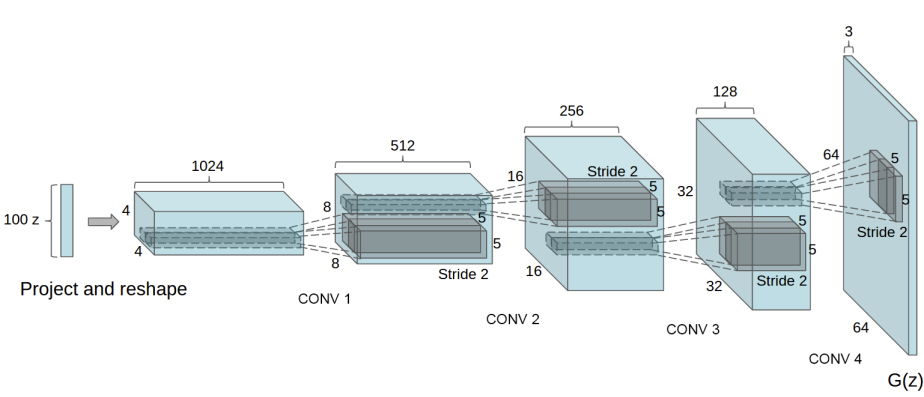

 Generator architecture [DCGAN paper]

In [12]:
#create the generator class 
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #input is z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            #state size (ngf*8)*4*4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #state size (ngf*4)*8*8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            #state size (ngf*2)*16*16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.ReLU(True),
            #state size (ngf)*32*32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            #state size (nc)*64*64
        )
    def forward(self, input):
        return self.main(input)
    

8. Instantiate the generator and save it in netG variable then we apply weight_init and we print our netG.

In [13]:
#Here we create instance of the generator class
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)


9. Create the Disciminator network  :

The discriminator will take input image of 3* 64 *64  and processes it through a serie of   conv2d ,BatchNorm2d, and LeakyReLU  layers and the final output through a sigmoid function to get the final probability.


In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #input is (nc)*64*64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #state size (ndf)*32*32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            #state size (ndf*2)*16*16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #state size (ndf*4)*8*8
            nn.Conv2d(ndf * 4, ndf *8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            #state size (ndf*8)*4*4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            #state size (nc)*64*64
        )
    def forward(self, input):
        return self.main(input)
    

 10. Instantiate the discriminator and save it in netD variable then we apply weight_init and we print our netD.

In [15]:
#Here we create instance of the Discriminator class
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


 11. Initialize Binary Cross-Entropy Loss function.


In [16]:
#we init BCELoss function
criterion = nn.BCELoss()
# we Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device = device)

# we create the real and fake labels during training
real_label = 1.
fake_label = 0.
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

# Train the DCGAN model :  

The training is split into 2 parts:
*  Part 1 to update the Discriminator :         
  * Maximize the probability of classifying real & fake data, in practice we need to maximize the value of ‘log(D(x))+log(1−D(G(z)))’,and because we have separate the mini-batch of fake & real inputs ,the calcule will be done in two steps : 1- construct real batch then calculate loss of log(D(x))   
        2- construct fake batch then calculate loss of log(1−D(G(z)))
   * Clculate the total loss then update D using adam optimizer.
  

*  Part 2 to update the Generator: 
   * Get the output from Part 1 with the Discriminator,computing G’s loss using real labels, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. 

In [17]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    epoch+=1
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float, device = device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device = device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # Save Losses for plotting later
    
        G_losses.append(errG.item())
        D_losses.append(errD.item())
      
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if epoch % 21 == 0:
            torch.save(netG, 'Generator_see999_epoch_{}.pth'.format(epoch))
            print(epoch)
            #print('Model saved.')


Starting Training Loop...
[1/8][0/1583]	Loss_D: 1.7430	Loss_G: 3.4901	D(x): 0.3834	D(G(z)): 0.3634 / 0.0447
[1/8][50/1583]	Loss_D: 0.2839	Loss_G: 28.6010	D(x): 0.8563	D(G(z)): 0.0000 / 0.0000
[1/8][100/1583]	Loss_D: 0.5136	Loss_G: 6.2022	D(x): 0.8334	D(G(z)): 0.0366 / 0.0056
[1/8][150/1583]	Loss_D: 0.3970	Loss_G: 10.3401	D(x): 0.9604	D(G(z)): 0.2740 / 0.0001
[1/8][200/1583]	Loss_D: 0.1172	Loss_G: 6.0409	D(x): 0.9540	D(G(z)): 0.0596 / 0.0047
[1/8][250/1583]	Loss_D: 0.1182	Loss_G: 4.3106	D(x): 0.9732	D(G(z)): 0.0706 / 0.0388
[1/8][300/1583]	Loss_D: 0.7296	Loss_G: 6.6333	D(x): 0.8359	D(G(z)): 0.3239 / 0.0039
[1/8][350/1583]	Loss_D: 0.4675	Loss_G: 3.6978	D(x): 0.8569	D(G(z)): 0.2198 / 0.0396
[1/8][400/1583]	Loss_D: 0.8262	Loss_G: 3.8946	D(x): 0.5634	D(G(z)): 0.0202 / 0.0379
[1/8][450/1583]	Loss_D: 0.5751	Loss_G: 3.3196	D(x): 0.8017	D(G(z)): 0.2020 / 0.0723
[1/8][500/1583]	Loss_D: 0.4517	Loss_G: 4.3322	D(x): 0.8172	D(G(z)): 0.1703 / 0.0225
[1/8][550/1583]	Loss_D: 0.3977	Loss_G: 4.4504	D(x):

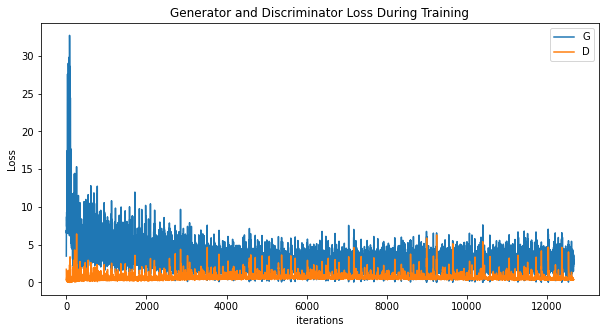

In [18]:
#After finishing the training process we visualise the variation of the Generator's loss & Discriminator loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

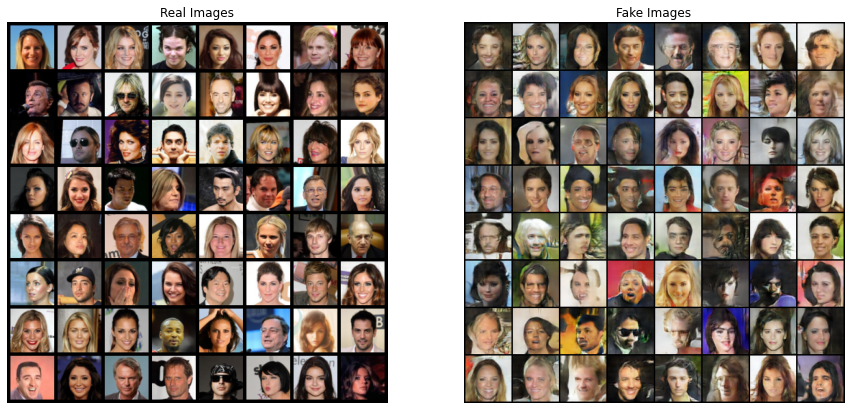

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


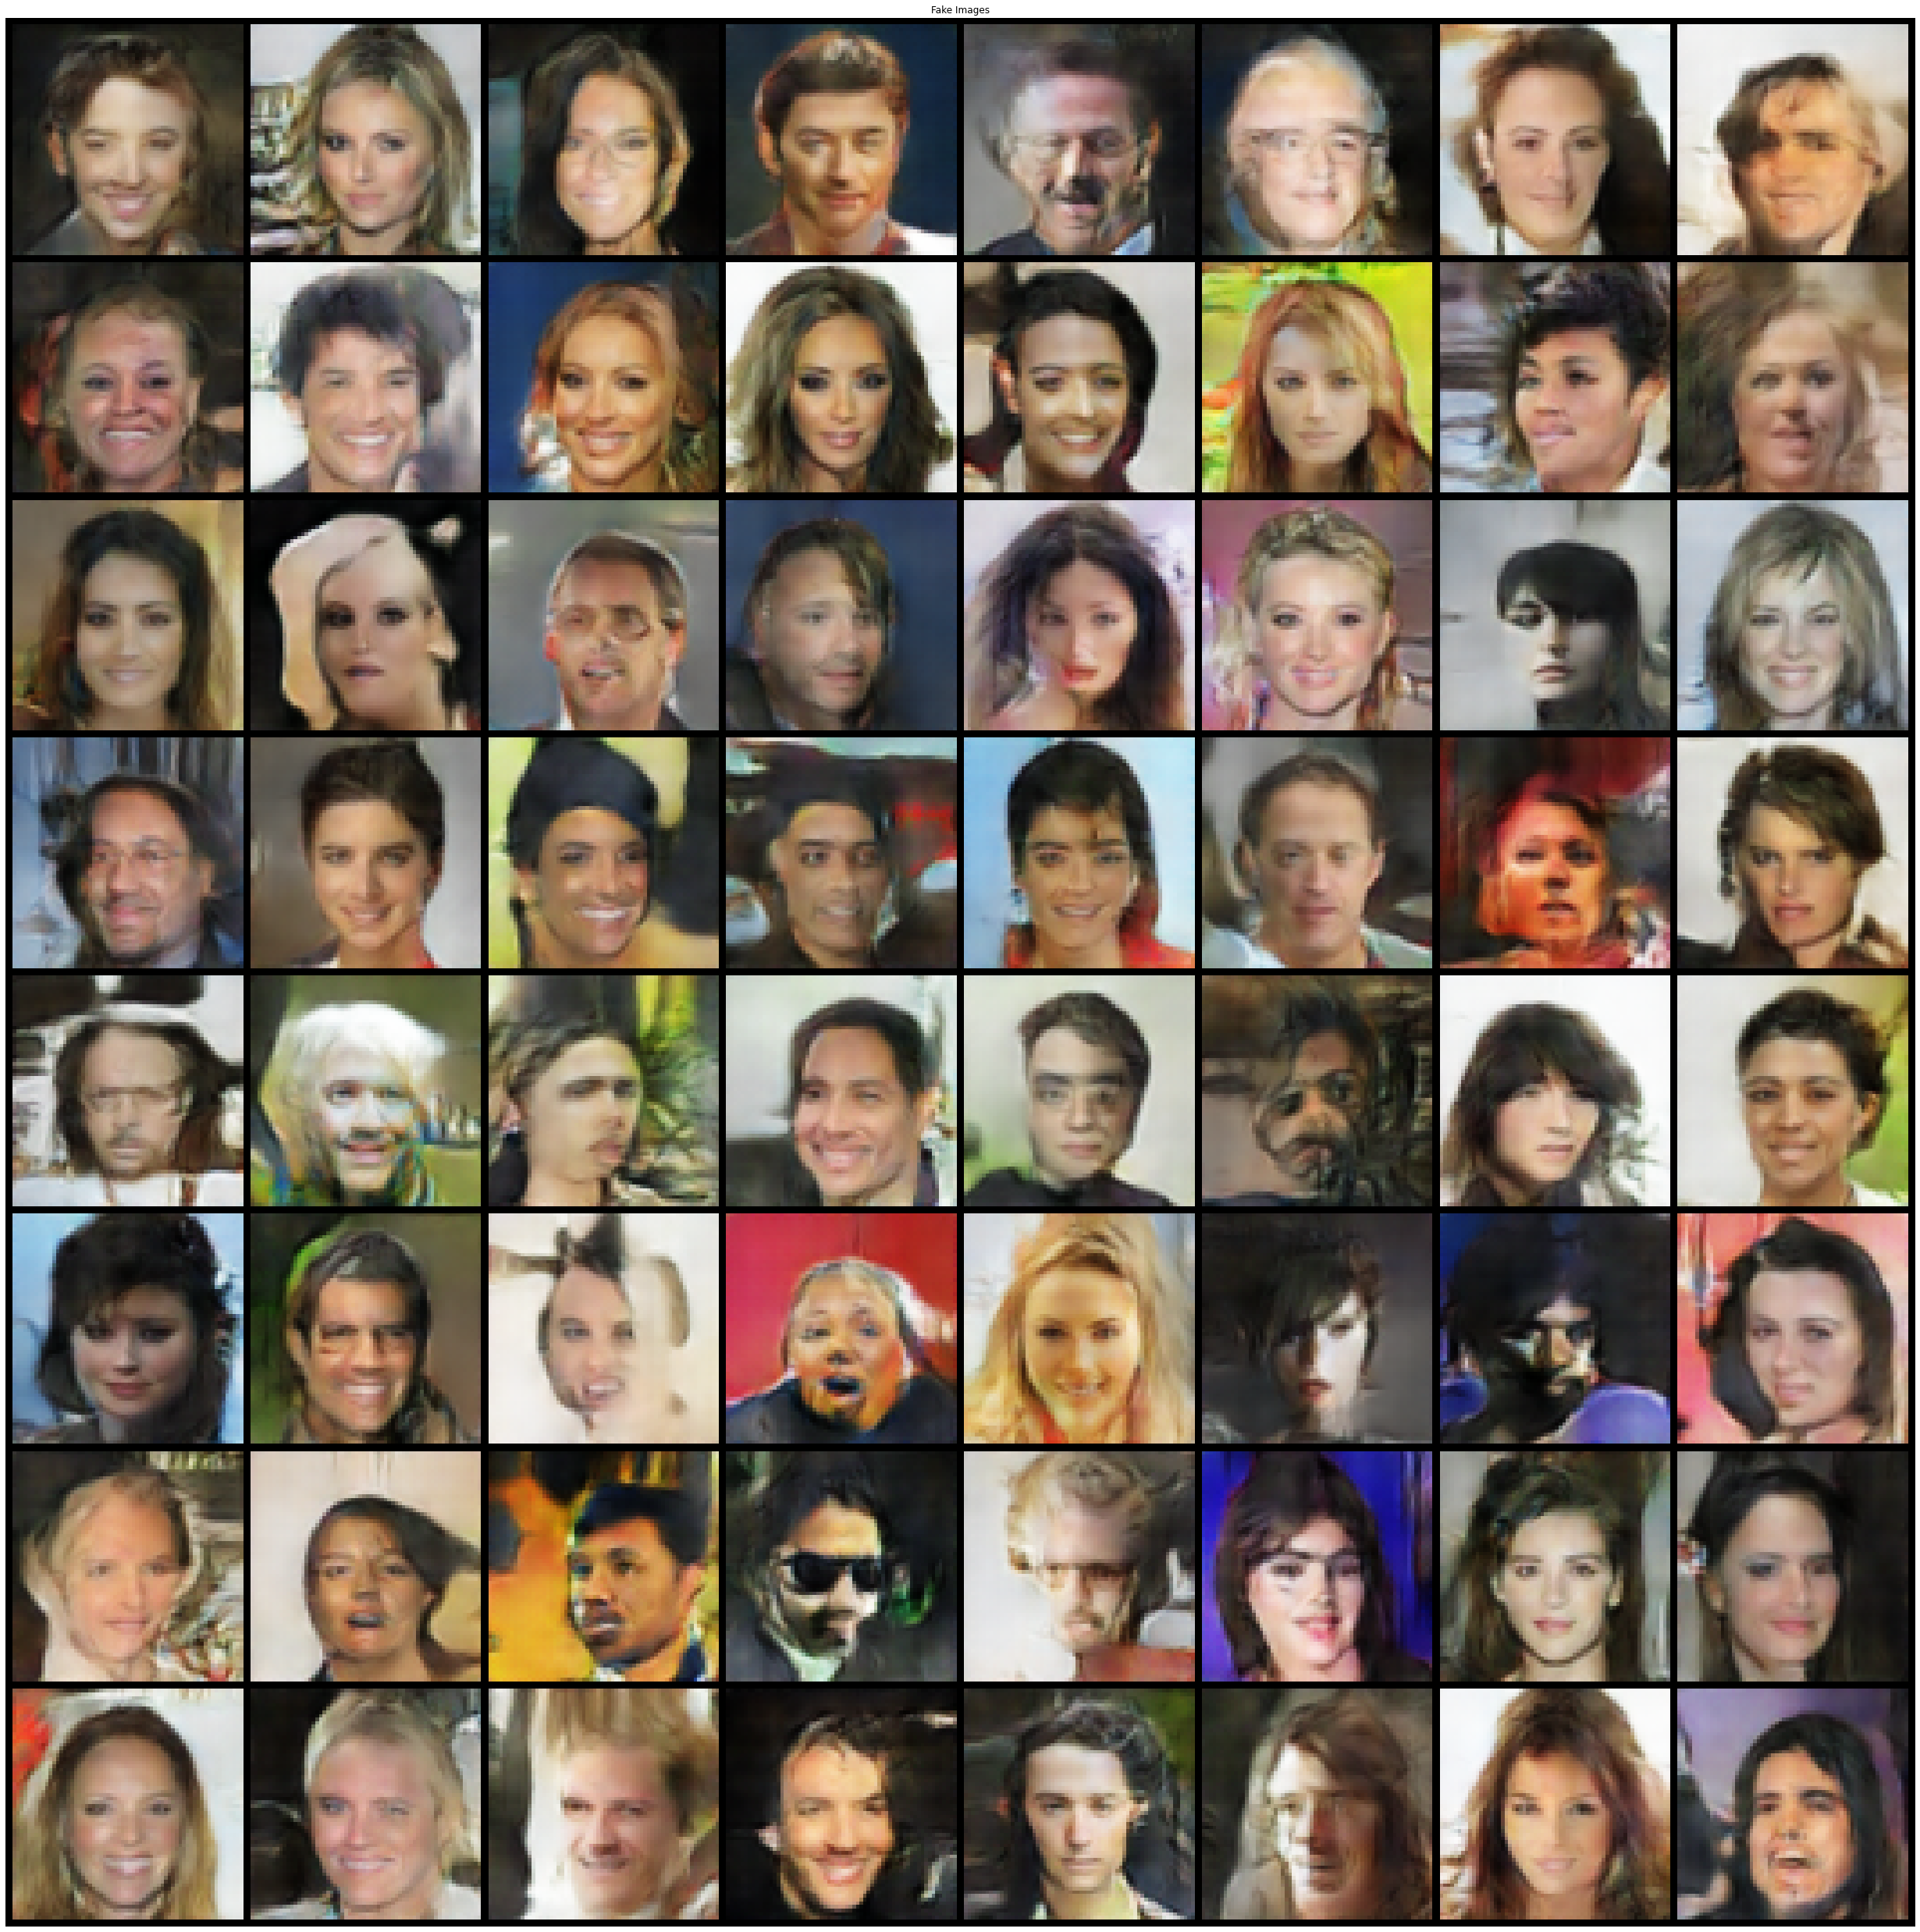

In [20]:
#%%capture
fig = plt.figure(figsize=(45,45))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()